In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
#df_train é utilizado para o treinamento
#df_test é utilizado para que as transformações que ocorrem no df_train também aconteçam no df_test

df_train = pd.read_csv('train.csv', sep="," , encoding="UTF8" )
df_test = pd.read_csv('test.csv', sep="," , encoding="UTF8" )

In [102]:
pd.set_option('display.max_columns', 999)

**Premissas**: Um candidato 'treineiro" é um candidato que, normalmente, ainda não terminou o ensino médio, pois, do contrário ele já poderia concorrer a uma vaga normalmente. Deste modo, um fator que pode impactar bastante é a idade, visto que são em sua maioria os candidatos mais jovens.

/home/vinicius/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1080x720 with 0 Axes>

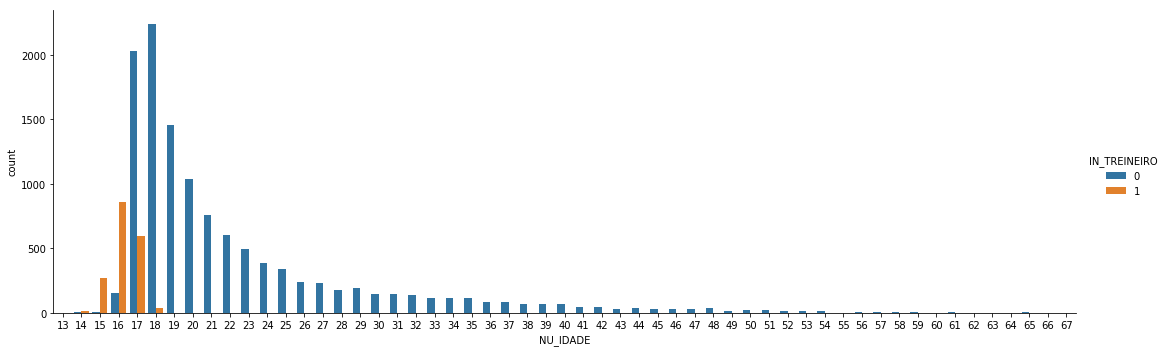

In [103]:
#verificando a distribuição das idades dos candidatos treineiros em relação aos demais candidatos.
plt.figure(figsize=(15,10))
g = sns.factorplot("NU_IDADE", data=df_train, aspect=3.0, kind='count', hue='IN_TREINEIRO')

É possível perceber pelo gráfico que os candidatos treineiros estão na faixa entre 14 e 18 anos.

/home/vinicius/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 864x504 with 0 Axes>

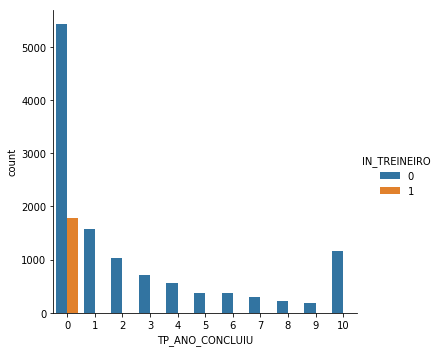

In [104]:
#verificando a distribuição dos candidatos treineiros pelo ano de conclusão do ensino médio
plt.figure(figsize=(12,7))
g = sns.factorplot("TP_ANO_CONCLUIU", data=df_train, aspect=1.0, kind='count', hue='IN_TREINEIRO')

Pelo gráfico, é possível notar que os candidatos treineiros não informaram o ano de conclusão (indicado por zero). Desta forma, percebe-se que dentre os candidatos treineiros, possivelmente nenhum tenha terminado o ensino médio.

/home/vinicius/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 864x504 with 0 Axes>

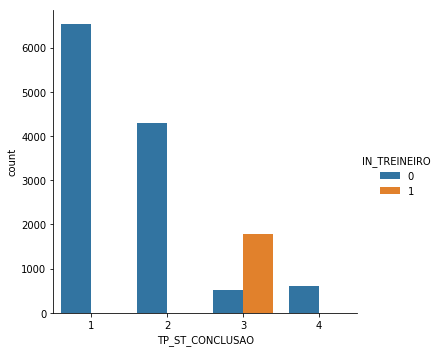

In [105]:
#verificando a distribuição dos candidatos treineiros pela situação de conclusão do ensino médio.
plt.figure(figsize=(12,7))
g = sns.factorplot("TP_ST_CONCLUSAO", data=df_train, aspect=1.0, kind='count', hue='IN_TREINEIRO')

Segundo o dicionário de dados, 'TP_ST_CONCLUSAO = 3' indica que o candidato está cursando o ensino médio e o concluirá após 2016. Neste caso, há ambos os tipos de candidatos (treneiros e não treineiros). Contudo, todos os candidatos treineiros estão nesta situação.

In [106]:
#selecionando as colunas analisadas para uma primeira versão do modelo
features = ['TP_ST_CONCLUSAO',    
           'TP_ANO_CONCLUIU',
           'NU_IDADE',
           ]

***Pré-processamento dos dados***

In [107]:
# Em relação à variável 'NU_IDADE' será feita uma discretização da mesma, com vistas a se ter intervalos de idade,
# de modo que a faixa de menor idade (<20 anos) seja uma das faixas..
from sklearn.preprocessing import KBinsDiscretizer

In [108]:
# Para a discretização, foi utilizada a estratégia "kmeans" para que fossem agrupadas as idades em faixas de
# valores por semelhança entre os candidatos.

# discretização para o conjunto de treino
disc_train = KBinsDiscretizer(n_bins=7, encode="onehot-dense", strategy="kmeans")
disc_train.fit(df_train[["NU_IDADE"]])
score_bins_uniform = disc_train.transform(df_train[["NU_IDADE"]]).astype(np.int)

In [109]:
# discretização para o conjunto de teste
disc_test = KBinsDiscretizer(n_bins=7, encode="onehot-dense", strategy="kmeans")
disc_test.fit(df_test[["NU_IDADE"]])
score_bins_uniform2 = disc_test.transform(df_test[["NU_IDADE"]]).astype(np.int)


In [110]:
#o código a seguir dá os limites de cada intervarlo

# para o conjunto treino
bin_edges_train = disc_train.bin_edges_[0]

# para o conjunto de teste
bin_edges_test = disc_test.bin_edges_[0]

In [111]:
# Definição de uma função para a geração dos intervalos
def get_interval(bin_idx, bin_edges):
    return f"{np.round(bin_edges[bin_idx], 2):.2f} ⊢ {np.round(bin_edges[bin_idx+1], 2):.2f}"

In [112]:
#variável que recebe uma lista com os intervalos gerados

# para o conjunto de treino
score_intervals_columns = [get_interval(i, bin_edges_train) for i in range(7)]

print(f"Bins: Kmeans")
print(f"intervalo: #elementos\n")
for i in range(len(disc_train.bin_edges_[0])-1):
    print(f"{get_interval(i, bin_edges_train)}: {sum(score_bins_uniform[:, i])}")

Bins: Kmeans
intervalo: #elementos

13.00 ⊢ 20.33: 8711
20.33 ⊢ 26.23: 2823
26.23 ⊢ 33.08: 1145
33.08 ⊢ 40.43: 610
40.43 ⊢ 48.26: 296
48.26 ⊢ 57.08: 118
57.08 ⊢ 67.00: 27


In [113]:
#variável que recebe uma lista com os intervalos gerados

# para o conjunto de teste
score_intervals_columns_test = [get_interval(i, bin_edges_test) for i in range(7)]

In [114]:
# O dataframe de treinamento recebe as nova colunas, referentes a cada um dos invervalos criados para a variável
# 'NU_IDADE'

df_train = pd.concat([df_train, pd.DataFrame(score_bins_uniform, columns=score_intervals_columns)], axis=1)

df_train.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,NO_ENTIDADE_CERTIFICACAO,CO_UF_ENTIDADE_CERTIFICACAO,SG_UF_ENTIDADE_CERTIFICACAO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050,13.00 ⊢ 20.33,20.33 ⊢ 26.23,26.23 ⊢ 33.08,33.08 ⊢ 40.43,40.43 ⊢ 48.26,48.26 ⊢ 57.08,57.08 ⊢ 67.00
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,4314902,Porto Alegre,43,RS,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,ABACCABDBEDEDEEDDDBBBDAABABECDCCCAAABCBEEABCA,BBEBCAEBCEDBDDEBCACDBCBDABDDCDBEDCEAEABCAADAC,99999DCABCABCBBCADBCBBABAEADBEEBEDAAABAEAECCBB...,AECCCBABDCADDBCBCCADADBBAADEBCEEBABCDDEAABCAA,1,BCADBCEDCCBADBDCADBEBDBEADCCAEACDBEDBCACAEBEE,BCBCCADCCBEDDBEEADBDCECCBBECAEEDDADCDDACAADBA,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEADDBECEBAEBC,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,B,B,3,C,A,B,B,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D,0,1,0,0,0,0,0
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2304707,Granja,23,CE,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,EDAAABDABADBCCAEDCDDECABADBEECBBAEEDCABCAABBC,ADCAABAADCEDAACDACEEDACBDCBACEDEDBACAADADABDC,99999ACBACDBDBCEADDAEEADCCEACEEDBECAAAACBECDAC...,AEDACBDECEDAEEAEDDEBDECDCECACADCACACAABDACEAB,1,EBEECADBCABECDDBEADCCABDEABEBCADBADDCCCEDBBCA,DCECBAAADCBBECAEDC

In [115]:
# O dataframe de teste recebe as nova colunas, referentes a cada um dos invervalos criados para a variável
# 'NU_IDADE'

df_test = pd.concat([df_test, pd.DataFrame(score_bins_uniform2, columns=score_intervals_columns)], axis=1)

In [116]:
# a variável 'features' recebe as novas colunas na lista de colunas
for i in score_intervals_columns:
    features.append(i)

In [117]:
features

['TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'NU_IDADE',
 '13.00 ⊢ 20.33',
 '20.33 ⊢ 26.23',
 '26.23 ⊢ 33.08',
 '33.08 ⊢ 40.43',
 '40.43 ⊢ 48.26',
 '48.26 ⊢ 57.08',
 '57.08 ⊢ 67.00']

In [118]:
#um dataframe 'features_train' é criado com as features selecionadas para o treinamento
features_train = df_train[features]

# target_train recebe a coluna para as classes a serem preditas
target_train = df_train['IN_TREINEIRO']

# para o conjunto de teste que gerará a saída do desafio
features_teste = df_test[features]

In [119]:
#excluindo a coluna original referente à idade dos conjunto de treinamento e teste
features_train.drop(['NU_IDADE'],axis=1,inplace=True)
features_teste.drop(['NU_IDADE'],axis=1,inplace=True)

/home/vinicius/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [120]:
#utilizando o get_dummies para a transformação das variáveis categóricas restantes
features_train = pd.get_dummies(features_train, columns=['TP_ST_CONCLUSAO','TP_ANO_CONCLUIU'], 
                         prefix=['TP_ST_CONCLUSAO','TP_ANO_CONCLUIU'])


features_teste = pd.get_dummies(features_teste, columns=['TP_ST_CONCLUSAO','TP_ANO_CONCLUIU'], 
                         prefix=['TP_ST_CONCLUSAO','TP_ANO_CONCLUIU'])

**NOTA**: Com as transformações feitas, todas as colunas possuem agora apenas valores binários, de modo que não se faz necessário a padronização dos dados...

***Treinamento do modelo***

In [121]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [122]:
X_train, X_test, y_train, y_test = train_test_split(features_train, target_train,test_size=0.33, random_state=42)

In [123]:
clf = SVC()
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [124]:
target_pred_test = clf.predict(X_test)

In [125]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, target_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, target_pred_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, target_pred_test)))

MAE: 0.023615096005296845
MSE: 0.023615096005296845
RMSE: 0.15367204041495916


In [126]:
accuracy_score(y_test, target_pred_test)

0.9763849039947031

In [127]:
confusion_matrix(y_test, target_pred_test)

array([[3821,  107],
       [   0,  603]])

In [128]:
from sklearn.metrics import classification_report
target_names = ['classe 0', 'classe 1']
print(classification_report(y_test, target_pred_test, target_names=target_names))

              precision    recall  f1-score   support

    classe 0       1.00      0.97      0.99      3928
    classe 1       0.85      1.00      0.92       603

    accuracy                           0.98      4531
   macro avg       0.92      0.99      0.95      4531
weighted avg       0.98      0.98      0.98      4531



**NOTA:** Com estes valores (acurácia, precision, recall e f1-score) a previsão feita para o arquivo de teste (arquivo de envio para a Codenation) resultou em um Score de aproximadamente 97%.

Contudo, pode ser percebido que o valor de 'precision' para a classe 1 está bem abaixo dos demais valores. Isso deve-se ao fato de que o classificador está aprendendo muito mais a classficar instâncias como sendo '0' (candidato não treineiro).

***Balanceamento das classes***

In [129]:
#testando NearMiss como método de Undersampling que iguala as quantidades de amostras entre as classes.
from imblearn.under_sampling import NearMiss

In [130]:
nr = NearMiss()

In [131]:
x_train, y_train = nr.fit_sample(features_train, target_train)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, random_state = 1, 
                                                    stratify=y_train)

In [133]:
clf = SVC()
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [134]:
target_pred_test = clf.predict(X_test)

In [135]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, target_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, target_pred_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, target_pred_test)))

MAE: 0.08632286995515695
MSE: 0.08632286995515695
RMSE: 0.2938075389692323


In [136]:
print(classification_report(y_test, target_pred_test, target_names=target_names))

              precision    recall  f1-score   support

    classe 0       1.00      0.83      0.91       446
    classe 1       0.85      1.00      0.92       446

    accuracy                           0.91       892
   macro avg       0.93      0.91      0.91       892
weighted avg       0.93      0.91      0.91       892



Com o Undersampling, pode ser percebido que não houve melhora nos valores referentes à classe 1. Além disso, a acurácia como um todo foi reduzida.

**OVERSAMPLING**

Testando com o SMOTE (Synthetic Minority Over-sampling Technique) que gera dados sintéticos para classe minoritária.

In [137]:
from imblearn.over_sampling import SMOTE

In [138]:
# sampling_strategy=0.5
smt = SMOTE(sampling_strategy=0.5)

In [139]:
x_train, y_train = smt.fit_sample(features_train, target_train)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

In [141]:
clf = SVC()
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [142]:
target_pred_test = clf.predict(X_test)

In [143]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, target_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, target_pred_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, target_pred_test)))

MAE: 0.020629015894487658
MSE: 0.020629015894487658
RMSE: 0.1436280470329095


In [144]:
print(classification_report(y_test, target_pred_test, target_names=target_names))

              precision    recall  f1-score   support

    classe 0       1.00      0.97      0.98      3953
    classe 1       0.94      1.00      0.97      1961

    accuracy                           0.98      5914
   macro avg       0.97      0.98      0.98      5914
weighted avg       0.98      0.98      0.98      5914



Com a utilização do OverSampling, é possível notar que houve uma melhora para os valores da classe 1, sem que houvesse perda na Classe 0. Além disso, a acurácia em relação ao modelo original se manteve.

**NOTA**: apesar da melhora em relação aos valores da Classe 1, o Score continuou em 97%, o mesmo atingido com as classes desbalanceadas.